In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

torch.set_printoptions(edgeitems=3, linewidth=120)
torch.manual_seed(123)

C:\Users\lenovo\anaconda3\envs\yolo\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 准备

## 提取数据

In [2]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 
               'frog', 'horse', 'ship', 'truck']
data_path = 'data/'

cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))


label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]

len(cifar10), len(cifar2)



Files already downloaded and verified
Files already downloaded and verified


(50000, 10000)

## 训练函数

In [3]:
def training_loop(n_epochs, model, optimizer, loss_fn, train_loader):
    
    for epoch in range(1, n_epochs + 1):
        each_epoch_loss = 0.0
        for imgs, labels in train_loader:

            imgs   = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            each_epoch_loss += loss
    
        current_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S.%f")[: -4]
        if epoch in {1, 2, 3, 4, 5} or epoch % 20 == 0:
            print(f'[Epoch: {epoch}] at {current_time} \nTraining Loss: {each_epoch_loss / len(train_loader):.4f}')
        if epoch == 6:
            print('    ...    ...   ...   ...   ...   ')
        if epoch % 20 == 1 and epoch != 1:
            print('    ...    ...   ...   ...   ...   ')
        



## 计算准确率

In [3]:
def calculate_accuracy(model, data_loader, model_name, loader_name='Validation'):
    
    correct = 0
    total   = 0
    
    with torch.no_grad():
        for imgs, labels in data_loader:
            
            imgs   = imgs.to(device)
            labels = labels.to(device)
            
            outputs = model(imgs)
            _, preds = torch.max(outputs, dim=1)
            total += labels.shape[0]
            correct += int((preds == labels).sum())
    
    correct_rate = correct / total
    print(f'Accuracy of Model [{model_name}] on [{loader_name}] set is {correct_rate:.4f}')
    return correct_rate


# 加宽模型

## 模型*WidenNet*

In [4]:
class WidenNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(3, 3), padding=1)
        self.fc1 = nn.Linear(16 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 16 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)

        return out
    

In [5]:
class WidenNet(nn.Module):
    def __init__(self, in_channels1=3, out_channels1=32):
        super().__init__()
        self.in_channels2  = out_channels1
        self.out_channels2 = out_channels1 // 2
        self.conv1 = nn.Conv2d(in_channels1, out_channels1, kernel_size=(3, 3), padding=1)
        self.conv2 = nn.Conv2d(self.in_channels2, self.out_channels2, kernel_size=(3, 3), padding=1)
        self.fc1 = nn.Linear(self.out_channels2 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
    
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, self.out_channels2 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)

        return out


## 训练

In [10]:
n_epochs = 100
batch_size = 64
learning_rate = 1e-2
model_name = 'WidenNet'

device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f'Training model [{model_name}] on deivce [{device}]... ...')

widennet = WidenNet().to(device)
optimizer = optim.SGD(widennet.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=batch_size, shuffle=True)


training_loop(
    
    n_epochs,
    widennet,
    optimizer, 
    loss_fn,
    train_loader
    
)


Training model [WidenNet] on deivce [cuda]... ...
[Epoch: 1] at 2023-07-27 10:54:47.20 
Training Loss: 0.5662
[Epoch: 2] at 2023-07-27 10:54:48.60 
Training Loss: 0.4752
[Epoch: 3] at 2023-07-27 10:54:50.00 
Training Loss: 0.4334
[Epoch: 4] at 2023-07-27 10:54:51.41 
Training Loss: 0.3907
[Epoch: 5] at 2023-07-27 10:54:52.82 
Training Loss: 0.3614
    ...    ...   ...   ...   ...   
[Epoch: 20] at 2023-07-27 10:55:13.91 
Training Loss: 0.2649
    ...    ...   ...   ...   ...   
[Epoch: 40] at 2023-07-27 10:55:41.95 
Training Loss: 0.2052
    ...    ...   ...   ...   ...   
[Epoch: 60] at 2023-07-27 10:56:09.94 
Training Loss: 0.1644
    ...    ...   ...   ...   ...   
[Epoch: 80] at 2023-07-27 10:56:38.12 
Training Loss: 0.1252
    ...    ...   ...   ...   ...   
[Epoch: 100] at 2023-07-27 10:57:06.32 
Training Loss: 0.0905


In [11]:
torch.save(widennet.state_dict(), 'model_parameters/widennet.pt')  # 只有模型的权重、没有结构


In [12]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader   = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

calculate_accuracy(widennet, train_loader, model_name, 'Train')
calculate_accuracy(widennet, val_loader, model_name)    
   

Accuracy of Model [WidenNet] on [Train] set is 0.9654
Accuracy of Model [WidenNet] on [Validation] set is 0.8945


# 正则化

## 初始模型

In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(3, 3), padding=1)
        self.fc1   = nn.Linear(8 * 8 * 8, 32)
        self.fc2   = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        
        return out
    

## 修改训练函数中损失的大小

In [12]:
def training_loop_L2Reg(n_epochs, model, optimizer, loss_fn, train_loader):
    
    for epoch in range(1, n_epochs + 1):
        each_epoch_loss = 0.0
        for imgs, labels in train_loader:

            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            L2_lambda = 0.001
            L2_norm = sum(params.pow(2.0).sum()
                          for params in model.parameters())
            loss = loss + L2_lambda * L2_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            each_epoch_loss += loss.item()

        current_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S.%f")[: -4]
        if epoch in {1, 2, 3, 4, 5} or epoch % 20 == 0:
            print(f'[Epoch: {epoch}] at {current_time} \nTraining Loss: {each_epoch_loss / len(train_loader):.4f}')
        if epoch == 6:
            print('    ...    ...   ...   ...   ...   ')
        if epoch % 20 == 1 and epoch != 1:
            print('    ...    ...   ...   ...   ...   ')
        
      


## 训练

In [14]:
n_epochs = 100
batch_size = 64
learning_rate = 1e-2
model_name = 'Net'

device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f'Training model [{model_name}] on deivce [{device}]... ...')

net = Net().to(device)
optimizer = optim.SGD(net.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=batch_size, shuffle=True)


training_loop_L2Reg(
    
    n_epochs,
    net,
    optimizer, 
    loss_fn,
    train_loader
    
)



Training model [Net] on deivce [cuda]... ...
[Epoch: 1] at 2023-07-26 20:06:04.46 
Training Loss: 0.5803
[Epoch: 2] at 2023-07-26 20:06:05.40 
Training Loss: 0.4978
[Epoch: 3] at 2023-07-26 20:06:06.45 
Training Loss: 0.4758
[Epoch: 4] at 2023-07-26 20:06:07.54 
Training Loss: 0.4567
[Epoch: 5] at 2023-07-26 20:06:08.67 
Training Loss: 0.4374
   ...    ...   ...   ...   ...   
[Epoch: 20] at 2023-07-26 20:06:21.95 
Training Loss: 0.3264
   ...    ...   ...   ...   ...   
[Epoch: 40] at 2023-07-26 20:06:41.57 
Training Loss: 0.2893
   ...    ...   ...   ...   ...   
[Epoch: 60] at 2023-07-26 20:07:02.46 
Training Loss: 0.2597
   ...    ...   ...   ...   ...   
[Epoch: 80] at 2023-07-26 20:07:23.80 
Training Loss: 0.2320
   ...    ...   ...   ...   ...   
[Epoch: 100] at 2023-07-26 20:07:41.12 
Training Loss: 0.2139


In [15]:
torch.save(net.state_dict(), 'model_parameters/net_L2Reg.pt')  # 只有模型的权重、没有结构


In [16]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader   = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

calculate_accuracy(net, train_loader, model_name, 'Train')
calculate_accuracy(net, val_loader, model_name)    
   

Accuracy of Model [Net] on [Train] set is 0.9303
Accuracy of Model [Net] on [Validation] set is 0.8855


# 随机清零神经元

## 添加*nn.Dropout*模块

In [7]:

class DropoutNet(nn.Module):
    def __init__(self, in_channels1=3, out_channels1=32):
        super().__init__()

        self.in_channels2 = out_channels1
        self.out_channels2 = out_channels1 // 2

        self.conv1 = nn.Conv2d(in_channels1, out_channels1, kernel_size=(3, 3), padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(self.in_channels2, self.out_channels2, kernel_size=(3, 3), padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)

        self.fc1 = nn.Linear(self.out_channels2 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, self.out_channels2 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)

        return out



## 训练

In [21]:
n_epochs = 100
batch_size = 64
learning_rate = 1e-2
model_name = 'DropoutNet'

device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f'Training model [{model_name}] on deivce [{device}]... ...')

dropoutnet = DropoutNet().to(device)
optimizer = optim.SGD(dropoutnet.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=batch_size, shuffle=True)


training_loop(
    
    n_epochs,
    dropoutnet,
    optimizer, 
    loss_fn,
    train_loader
    
)


Training model [DropoutNet] on deivce [cuda]... ...
[Epoch: 1] at 2023-07-26 20:17:46.08 
Training Loss: 0.5744
[Epoch: 2] at 2023-07-26 20:17:46.81 
Training Loss: 0.4904
[Epoch: 3] at 2023-07-26 20:17:47.51 
Training Loss: 0.4646
[Epoch: 4] at 2023-07-26 20:17:48.20 
Training Loss: 0.4439
[Epoch: 5] at 2023-07-26 20:17:48.93 
Training Loss: 0.4170
   ...    ...   ...   ...   ...   
[Epoch: 20] at 2023-07-26 20:17:59.13 
Training Loss: 0.3482
   ...    ...   ...   ...   ...   
[Epoch: 40] at 2023-07-26 20:18:13.48 
Training Loss: 0.3099
   ...    ...   ...   ...   ...   
[Epoch: 60] at 2023-07-26 20:18:27.82 
Training Loss: 0.2824
   ...    ...   ...   ...   ...   
[Epoch: 80] at 2023-07-26 20:18:42.42 
Training Loss: 0.2594
   ...    ...   ...   ...   ...   
[Epoch: 100] at 2023-07-26 20:18:56.05 
Training Loss: 0.2434


In [22]:
torch.save(dropoutnet.state_dict(), 'model_parameters/dropoutnet.pt')  # 只有模型的权重、没有结构


In [23]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader   = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

calculate_accuracy(dropoutnet, train_loader, model_name, 'Train')
calculate_accuracy(dropoutnet, val_loader, model_name)    
   

Accuracy of Model [DropoutNet] on [Train] set is 0.9000
Accuracy of Model [DropoutNet] on [Validation] set is 0.8770


# 批量归一化

## 添加*nn.BatchNorm*模块

In [8]:
class BatchNormNet(nn.Module):
    def __init__(self, in_channels1=3, out_channels1=32):
        super().__init__()

        self.in_channels2 = out_channels1
        self.out_channels2 = out_channels1 // 2

        self.conv1 = nn.Conv2d(in_channels1, out_channels1, kernel_size=(3, 3), padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=out_channels1)
        self.conv2 = nn.Conv2d(self.in_channels2, self.out_channels2, kernel_size=(3, 3), padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=self.out_channels2)

        self.fc1 = nn.Linear(self.out_channels2 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, self.out_channels2 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)

        return out

##  训练

In [7]:
n_epochs = 100
batch_size = 64
learning_rate = 1e-2
model_name = 'BatchNormNet'

device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f'Training model [{model_name}] on deivce [{device}]... ...')

batchnormnet = BatchNormNet().to(device)
optimizer = optim.SGD(batchnormnet.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=batch_size, shuffle=True)


training_loop(
    
    n_epochs,
    batchnormnet,
    optimizer, 
    loss_fn,
    train_loader
    
)


Training model [BatchNormNet] on deivce [cuda]... ...
[Epoch: 1] at 2023-07-26 20:30:49.42 
Training Loss: 0.4588
[Epoch: 2] at 2023-07-26 20:30:50.25 
Training Loss: 0.3721
[Epoch: 3] at 2023-07-26 20:30:51.11 
Training Loss: 0.3459
[Epoch: 4] at 2023-07-26 20:30:51.93 
Training Loss: 0.3303
[Epoch: 5] at 2023-07-26 20:30:52.77 
Training Loss: 0.3199
    ...    ...   ...   ...   ...   
[Epoch: 20] at 2023-07-26 20:31:05.07 
Training Loss: 0.2159
    ...    ...   ...   ...   ...   
[Epoch: 40] at 2023-07-26 20:31:21.45 
Training Loss: 0.1312
    ...    ...   ...   ...   ...   
[Epoch: 60] at 2023-07-26 20:31:37.96 
Training Loss: 0.0755
    ...    ...   ...   ...   ...   
[Epoch: 80] at 2023-07-26 20:31:54.14 
Training Loss: 0.0405
    ...    ...   ...   ...   ...   
[Epoch: 100] at 2023-07-26 20:32:10.47 
Training Loss: 0.0243


In [8]:
torch.save(batchnormnet.state_dict(), 'model_parameters/batchnormnet.pt')  # 只有模型的权重、没有结构


In [9]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader   = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

calculate_accuracy(batchnormnet, train_loader, model_name, 'Train')
calculate_accuracy(batchnormnet, val_loader, model_name)    
  

Accuracy of Model [BatchNormNet] on [Train] set is 0.9499
Accuracy of Model [BatchNormNet] on [Validation] set is 0.8475


# 深化模型

## 增加卷积层

In [9]:
class DeepenNet(nn.Module):
    def __init__(self, in_channels1=3, out_channels1=32):
        super().__init__()

        self.in_channels2  = out_channels1
        self.out_channels2 = out_channels1 // 2
        self.in_channels3  = out_channels1 // 2
        self.out_channels3 = out_channels1 // 2

        self.conv1 = nn.Conv2d(in_channels1, out_channels1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(self.in_channels2, self.out_channels2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(self.in_channels3, self.out_channels3, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(self.out_channels3 * 4 * 4, 32)
        self.fc2 = nn.Linear(32, 2)
    
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
        out = out.view(-1, self.out_channels3 * 4 * 4)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)

        return out
 

## 训练

In [11]:
n_epochs = 100
batch_size = 64
learning_rate = 1e-2
model_name = 'DeepenNet'

device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f'Training model [{model_name}] on deivce [{device}]... ...')

deepennet = DeepenNet().to(device)
optimizer = optim.SGD(deepennet.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=batch_size, shuffle=True)


training_loop(
    
    n_epochs,
    deepennet,
    optimizer, 
    loss_fn,
    train_loader
    
)


Training model [DeepenNet] on deivce [cuda]... ...
[Epoch: 1] at 2023-07-26 20:34:10.31 
Training Loss: 0.6911
[Epoch: 2] at 2023-07-26 20:34:11.19 
Training Loss: 0.6628
[Epoch: 3] at 2023-07-26 20:34:11.93 
Training Loss: 0.5931
[Epoch: 4] at 2023-07-26 20:34:12.74 
Training Loss: 0.5308
[Epoch: 5] at 2023-07-26 20:34:13.60 
Training Loss: 0.4955
    ...    ...   ...   ...   ...   
[Epoch: 20] at 2023-07-26 20:34:26.06 
Training Loss: 0.3073
    ...    ...   ...   ...   ...   
[Epoch: 40] at 2023-07-26 20:34:43.12 
Training Loss: 0.2359
    ...    ...   ...   ...   ...   
[Epoch: 60] at 2023-07-26 20:34:59.85 
Training Loss: 0.1817
    ...    ...   ...   ...   ...   
[Epoch: 80] at 2023-07-26 20:35:16.78 
Training Loss: 0.1313
    ...    ...   ...   ...   ...   
[Epoch: 100] at 2023-07-26 20:35:33.15 
Training Loss: 0.0886


In [12]:
torch.save(deepennet.state_dict(), 'model_parameters/deepennet.pt')  # 只有模型的权重、没有结构


In [13]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader   = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

calculate_accuracy(deepennet, train_loader, model_name, 'Train')
calculate_accuracy(deepennet, val_loader, model_name)    
  

Accuracy of Model [DeepenNet] on [Train] set is 0.9683
Accuracy of Model [DeepenNet] on [Validation] set is 0.9050


# 残差模型

## 整合输出
- 将之前卷积层的输出和最后一层激活后的卷积一起池化

In [10]:
class ResNet(nn.Module):
    def __init__(self, in_channels1=3, out_channels1=32):
        super().__init__()

        self.in_channels2  = out_channels1
        self.out_channels2 = out_channels1 // 2
        self.in_channels3  = out_channels1 // 2
        self.out_channels3 = out_channels1 // 2

        self.conv1 = nn.Conv2d(in_channels1 ,out_channels1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(self.in_channels2, self.out_channels2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(self.in_channels3, self.out_channels3, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(self.out_channels3 * 4 * 4, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out1 = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out2 = F.max_pool2d(torch.relu(self.conv2(out1)), 2)
        out3 = F.max_pool2d(torch.relu(self.conv3(out2)) + out2, 2)
        out3 = out3.view(-1, self.out_channels3 * 4 * 4)
        out4 = torch.relu(self.fc1(out3))
        out5 = self.fc2(out4)

        return out5

## 训练

In [19]:
n_epochs = 100
batch_size = 64
learning_rate = 1e-2
model_name = 'ResNet'

device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f'Training model [{model_name}] on deivce [{device}]... ...')

resnet = ResNet().to(device)
optimizer = optim.SGD(resnet.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=batch_size, shuffle=True)


training_loop(
    
    n_epochs,
    resnet,
    optimizer, 
    loss_fn,
    train_loader
    
)


Training model [ResNet] on deivce [cuda]... ...
[Epoch: 1] at 2023-07-26 20:39:13.34 
Training Loss: 0.6302
[Epoch: 2] at 2023-07-26 20:39:14.08 
Training Loss: 0.5092
[Epoch: 3] at 2023-07-26 20:39:15.04 
Training Loss: 0.4323
[Epoch: 4] at 2023-07-26 20:39:15.87 
Training Loss: 0.3876
[Epoch: 5] at 2023-07-26 20:39:16.72 
Training Loss: 0.3644
    ...    ...   ...   ...   ...   
[Epoch: 20] at 2023-07-26 20:39:29.66 
Training Loss: 0.2842
    ...    ...   ...   ...   ...   
[Epoch: 40] at 2023-07-26 20:39:46.94 
Training Loss: 0.2184
    ...    ...   ...   ...   ...   
[Epoch: 60] at 2023-07-26 20:40:03.51 
Training Loss: 0.1649
    ...    ...   ...   ...   ...   
[Epoch: 80] at 2023-07-26 20:40:20.37 
Training Loss: 0.1204
    ...    ...   ...   ...   ...   
[Epoch: 100] at 2023-07-26 20:40:37.11 
Training Loss: 0.0754


In [20]:
torch.save(resnet.state_dict(), 'model_parameters/resnet.pt')  # 只有模型的权重、没有结构


In [21]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader   = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

calculate_accuracy(resnet, train_loader, model_name, 'Train')
calculate_accuracy(resnet, val_loader, model_name)    
  

Accuracy of Model [ResNet] on [Train] set is 0.9766
Accuracy of Model [ResNet] on [Validation] set is 0.8995


# 更深的残差模型

## 构建残差块

In [11]:
class ResBlock(nn.Module):
    def __init__(self, n_channels):
        super(ResBlock, self).__init__()

        self.conv = nn.Conv2d(n_channels, n_channels, kernel_size=3, padding=1, bias=False)
        self.batchnorm = nn.BatchNorm2d(num_features=n_channels)

        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
        torch.nn.init.constant_(self.batchnorm.weight, 0.5)
        torch.nn.init.zeros_(self.batchnorm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batchnorm(out)
        out = torch.relu(out)

        return out + x

    
class DeepenResNet(nn.Module):
    def __init__(self, n_channels=32, n_blocks=10):
        super().__init__()
        self.n_channels = n_channels
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_channels, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_channels=n_channels)])
        )
        self.fc1 = nn.Linear(n_channels * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, self.n_channels * 8 * 8)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)

        return out


## 训练

In [15]:
n_epochs = 100
batch_size = 64
learning_rate = 3e-3
model_name = 'DeepenResNet'

device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f'Training model [{model_name}] on deivce [{device}]... ...')

deepenresnet = DeepenResNet().to(device)
optimizer = optim.SGD(deepenresnet.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=batch_size, shuffle=True)


training_loop(
    
    n_epochs,
    deepenresnet,
    optimizer, 
    loss_fn,
    train_loader
    
)



Training model [DeepenResNet] on deivce [cuda]... ...
[Epoch: 1] at 2023-07-27 10:58:17.95 
Training Loss: 0.4709
[Epoch: 2] at 2023-07-27 10:58:24.75 
Training Loss: 0.3874
[Epoch: 3] at 2023-07-27 10:58:31.54 
Training Loss: 0.3520
[Epoch: 4] at 2023-07-27 10:58:38.33 
Training Loss: 0.3262
[Epoch: 5] at 2023-07-27 10:58:45.16 
Training Loss: 0.3101
    ...    ...   ...   ...   ...   
[Epoch: 20] at 2023-07-27 11:00:27.67 
Training Loss: 0.1778
    ...    ...   ...   ...   ...   
[Epoch: 40] at 2023-07-27 11:02:43.95 
Training Loss: 0.0608
    ...    ...   ...   ...   ...   
[Epoch: 60] at 2023-07-27 11:04:59.79 
Training Loss: 0.0189
    ...    ...   ...   ...   ...   
[Epoch: 80] at 2023-07-27 11:07:16.23 
Training Loss: 0.0051
    ...    ...   ...   ...   ...   
[Epoch: 100] at 2023-07-27 11:09:32.10 
Training Loss: 0.0054


In [16]:
torch.save(deepenresnet.state_dict(), 'model_parameters/deepenresnet.pt')  # 只有模型的权重、没有结构


In [17]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader   = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

calculate_accuracy(deepenresnet, train_loader, model_name, 'Train')
calculate_accuracy(deepenresnet, val_loader, model_name)    
  

Accuracy of Model [DeepenResNet] on [Train] set is 0.9999
Accuracy of Model [DeepenResNet] on [Validation] set is 0.8915


# 对比模型

## 计算模型在训练集和测试集上的准确率

In [12]:
file_names = ['widennet.pt', 'net_L2Reg.pt', 'dropoutnet.pt', 
              'batchnormnet.pt', 'deepennet.pt', 'resnet.pt', 'deepenresnet.pt']
nets = [WidenNet(), Net(), DropoutNet(), BatchNormNet(), DeepenNet(), ResNet(), DeepenResNet()]
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f'Calculating accuracy on deivce [{device}]... ...\n')

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader   = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)
train_accuracy = []
val_accuracy = []

for net, file_name in zip(nets, file_names):
    
    model = net.to(device)
    model_name = file_name[: -3]
    model.load_state_dict(torch.load('model_parameters/' + file_name, map_location=device))
    
    train_accuracy.append(calculate_accuracy(net, train_loader, model_name, 'Train'))
    val_accuracy.append(calculate_accuracy(net, val_loader, model_name))
    print('*-----------------------------------------------------------*')

    
accuracy = np.array([train_accuracy, val_accuracy])
train_accuracy, val_accuracy, accuracy

Calculating accuracy on deivce [cuda]... ...

Accuracy of Model [widennet] on [Train] set is 0.9654
Accuracy of Model [widennet] on [Validation] set is 0.8945
*-----------------------------------------------------------*
Accuracy of Model [net_L2Reg] on [Train] set is 0.9303
Accuracy of Model [net_L2Reg] on [Validation] set is 0.8855
*-----------------------------------------------------------*
Accuracy of Model [dropoutnet] on [Train] set is 0.8935
Accuracy of Model [dropoutnet] on [Validation] set is 0.8725
*-----------------------------------------------------------*
Accuracy of Model [batchnormnet] on [Train] set is 0.9499
Accuracy of Model [batchnormnet] on [Validation] set is 0.8475
*-----------------------------------------------------------*
Accuracy of Model [deepennet] on [Train] set is 0.9683
Accuracy of Model [deepennet] on [Validation] set is 0.9050
*-----------------------------------------------------------*
Accuracy of Model [resnet] on [Train] set is 0.9766
Accuracy of

([0.9654, 0.9303, 0.8935, 0.9499, 0.9683, 0.9766, 0.9999],
 [0.8945, 0.8855, 0.8725, 0.8475, 0.905, 0.8995, 0.8915],
 array([[0.9654, 0.9303, 0.8935, 0.9499, 0.9683, 0.9766, 0.9999],
        [0.8945, 0.8855, 0.8725, 0.8475, 0.905 , 0.8995, 0.8915]]))

## 绘制柱状图

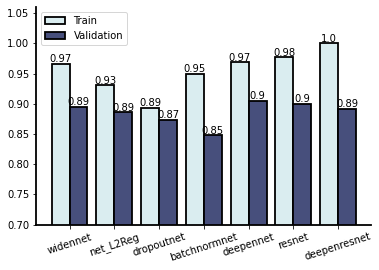

In [50]:
fig, ax = plt.subplots(nrows=1, ncols=1)
model_names = [name.replace('.pt', '') for name in file_names]
labels = ['Train', 'Validation']

n_variables = 7
n_bars = 2
x = np.arange(n_variables) * n_bars
width = .8
adjust = [width * i 
          for i in [bar_loc - (n_bars - 1) / 2 for bar_loc in range(n_bars)]]
colors = sns.cubehelix_palette(n_colors=n_bars, rot=-0.2, gamma=0.6)


for (acc, adjust, color, label) in zip(accuracy, adjust, colors, labels):
    
    bar = ax.bar(x=x + adjust, height=acc, width=width, label=label,
                 color=color, edgecolor='black', linewidth=1.8)
    for rect in bar:
        height = rect.get_height()
        ax.text(x=rect.get_x() + rect.get_width() / 2, y=height, 
                s=str(round(height, 2)), ha='center', va='bottom')
    
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=18)
ax.set_ylim(0.7, 1.06)
ax.legend()


ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['left'].set_linewidth(1.8)
ax.spines['bottom'].set_linewidth(1.8)

